## Assignment: Machine Translation: A Comparative Experiment

In [1]:
## necessary imports
import pandas as pd
import numpy as np 
from deep_translator import GoogleTranslator
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import sacrebleu
import matplotlib.pyplot as plt
import nltk
from collections import Counter 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, TimeDistributed
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### Defining the sentences to be translated with their respective libre translation (No free api was found sadly, so translated them manually on Libre website)

In [4]:
arabic_sentences = [
    "لقد كان يوما طويلا ولكنه كان ممتعا للغاية.",
    "عندما وصلت إلى المنزل، وجدت رسالة من صديقي.",
    "الحياة مليئة بالتحديات ولكننا نواصل المضي قدما."
]

english_reference = [
    "It was a long day, but it was incredibly enjoyable.",
    "When I got home, I found a letter from my friend.",
    "Life is full of challenges, but we keep moving forward."
]

Libre_translation = ["It's been a long day, but it was so fun. - What?", 
                     "When I got home, I found a message from my friend. - What?",
                     "Life is full of challenges, but we keep moving."]

#### Comparison functionality

LibreTranslate BLEU Score: 61.405870890269355
Google Translator BLEU Score: 71.45429028534373


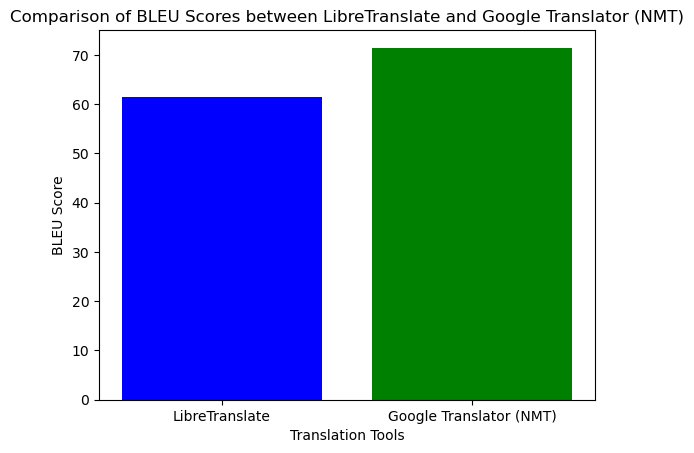

In [5]:

translator = GoogleTranslator(source='arabic', target='english')
google_translations = [translator.translate(sentence) for sentence in arabic_sentences]

reference = [english_reference]

libre_bleu = sacrebleu.corpus_bleu(Libre_translation, reference)
google_bleu = sacrebleu.corpus_bleu(google_translations, reference)

print(f"LibreTranslate BLEU Score: {libre_bleu.score}")
print(f"Google Translator BLEU Score: {google_bleu.score}")

tools = ['LibreTranslate', 'Google Translator (NMT)']
bleu_scores = [libre_bleu.score, google_bleu.score]

plt.bar(tools, bleu_scores, color=['blue', 'green'])
plt.xlabel('Translation Tools')
plt.ylabel('BLEU Score')
plt.title('Comparison of BLEU Scores between LibreTranslate and Google Translator (NMT)')
plt.show()


#### From scratch model - Kaggle dataset: https://www.kaggle.com/datasets/samirmoustafa/arabic-to-english-translation-sentences

In [6]:
with open('ara_eng.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()
english_sentences = []
arabic_sentences = []

for line in lines:
    if '\t' in line:  
        english, arabic = line.strip().split('\t')
        english_sentences.append(english)
        arabic_sentences.append(arabic)

print("English Sentences:")
print(english_sentences[:10])  
print("Arabic Sentences:")
print(arabic_sentences[:10])    


def preprocess_sentences(english_sentences, arabic_sentences):
    english_tokenized = [word_tokenize(sentence) for sentence in english_sentences]
    arabic_tokenized = [word_tokenize(sentence) for sentence in arabic_sentences]
    
    return english_tokenized, arabic_tokenized

english_tokenized, arabic_tokenized = preprocess_sentences(english_sentences, arabic_sentences)

print("Tokenized English Sentences:")
print(english_tokenized[:10]) 
print("Tokenized Arabic Sentences:")
print(arabic_tokenized[:10])    


English Sentences:
['Hi.', 'Run!', 'Help!', 'Jump!', 'Stop!', 'Go on.', 'Go on.', 'Hello!', 'Hurry!', 'Hurry!']
Arabic Sentences:
['مرحبًا.', 'اركض!', 'النجدة!', 'اقفز!', 'قف!', 'داوم.', 'استمر.', 'مرحباً.', 'تعجّل!', 'استعجل!']
Tokenized English Sentences:
[['Hi', '.'], ['Run', '!'], ['Help', '!'], ['Jump', '!'], ['Stop', '!'], ['Go', 'on', '.'], ['Go', 'on', '.'], ['Hello', '!'], ['Hurry', '!'], ['Hurry', '!']]
Tokenized Arabic Sentences:
[['مرحبًا', '.'], ['اركض', '!'], ['النجدة', '!'], ['اقفز', '!'], ['قف', '!'], ['داوم', '.'], ['استمر', '.'], ['مرحباً', '.'], ['تعجّل', '!'], ['استعجل', '!']]


In [7]:
from collections import Counter

def create_vocabulary(sentences):
    word_counts = Counter(word for sentence in sentences for word in sentence)
    vocab = {word: idx for idx, (word, _) in enumerate(word_counts.items())}
    vocab['<PAD>'] = len(vocab)
    vocab['<UNK>'] = len(vocab)
    return vocab

english_vocab = create_vocabulary(english_tokenized)
arabic_vocab = create_vocabulary(arabic_tokenized)

print(f"English Vocabulary Size: {len(english_vocab)}")
print(f"Arabic Vocabulary Size: {len(arabic_vocab)}")


English Vocabulary Size: 26659
Arabic Vocabulary Size: 57873


In [8]:
def encode_sentences(sentences, vocab):
    return [[vocab.get(word, vocab['<UNK>']) for word in sentence] for sentence in sentences]

encoded_english = encode_sentences(english_tokenized, english_vocab)
encoded_arabic = encode_sentences(arabic_tokenized, arabic_vocab)

print("Encoded English Sentences:", encoded_english[:5]) 
print("Encoded Arabic Sentences:", encoded_arabic[:5])   


Encoded English Sentences: [[0, 1], [2, 3], [4, 3], [5, 3], [6, 3]]
Encoded Arabic Sentences: [[0, 1], [2, 3], [4, 3], [5, 3], [6, 3]]


In [11]:
max_length = max(max(len(seq) for seq in encoded_english), max(len(seq) for seq in encoded_arabic))

padded_encoded_english = pad_sequences(encoded_english, maxlen=max_length, padding='post')
padded_encoded_arabic = pad_sequences(encoded_arabic, maxlen=max_length, padding='post')

print("Padded Encoded English Shape:", padded_encoded_english.shape)
print("Padded Encoded Arabic Shape:", padded_encoded_arabic.shape)


Padded Encoded English Shape: (24638, 226)
Padded Encoded Arabic Shape: (24638, 226)


In [12]:
embedding_dim = 256
units = 512

encoder_input = Input(shape=(None,))
encoder_embedding = Embedding(input_dim=len(english_vocab), output_dim=embedding_dim)(encoder_input)
encoder_lstm = LSTM(units, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

decoder_input = Input(shape=(None,))
decoder_embedding = Embedding(input_dim=len(arabic_vocab), output_dim=embedding_dim)(decoder_input)
decoder_lstm = LSTM(units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(len(arabic_vocab), activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_input, decoder_input], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, None, 256)            6824704   ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, None, 256)            1481548   ['input_2[0][0]']             
                                                          8                                 

In [ ]:
decoder_input_data = np.zeros_like(padded_encoded_arabic)
decoder_input_data[:, 1:] = padded_encoded_arabic[:, :-1]
decoder_output_data = np.expand_dims(padded_encoded_arabic, -1)  

model.fit([padded_encoded_english, decoder_input_data], decoder_output_data, 
          batch_size=64, 
          epochs=100, 
          validation_split=0.2)

Epoch 1/100


